# Plot Aggregated PSTH Timecourses

Visualize PSTH results from multi-run simulations with error bars (mean ± SEM).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

## Load Aggregated Data

In [ ]:
# Auto-detect the most recent multi-run output
import json
from datetime import datetime

# Find all multirun directories
base_output = Path("./models_output/test_multirun_minimal")
multirun_dirs = sorted(base_output.glob("multirun_*"), key=lambda x: x.stat().st_mtime, reverse=True)

if not multirun_dirs:
    raise FileNotFoundError(f"No multirun directories found in {base_output}")

# Use the most recent one
latest_run_dir = multirun_dirs[0]
print(f"📁 Using latest run: {latest_run_dir.name}\n")

# Load and display run summary
summary_file = latest_run_dir / "run_summary.json"
if summary_file.exists():
    with open(summary_file, 'r') as f:
        summary = json.load(f)

    print("═" * 70)
    print("RUN SUMMARY")
    print("═" * 70)
    print(f"Timestamp: {summary['experiment_info']['timestamp']}")
    print(f"Runs: {summary['configuration']['num_runs']}")
    print(f"Workers: {summary['configuration']['num_workers']}")
    print(f"CFs: {summary['configuration']['num_cf']}")
    print(f"ANF: {summary['configuration']['num_ANF']}")
    print(f"\nTiming:")
    print(f"  Wall time: {summary['timing']['wall_time_minutes']:.2f} minutes")
    print(f"  Avg runtime/run: {summary['timing']['average_runtime_per_run']:.2f} seconds")
    print(f"\nMemory:")
    print(f"  Peak: {summary['memory']['peak_memory_gb']:.3f} GB")
    print(f"  Avg peak: {summary['memory']['average_peak_memory_gb']:.3f} GB")
    print("═" * 70)
else:
    print("⚠️  No run summary found")

aggregated_dir = latest_run_dir / "aggregated"

📁 Using latest run: multirun_50runs_30cf_64-64-64anf_1files_20260216_160316

⚠️  No run summary found


In [11]:
# Get the first wav file from the aggregated directory
aggregated_files = sorted(aggregated_dir.glob("*.npz"))
aggregated_files = [f for f in aggregated_files if not f.name.endswith('_stats.npz')]

if not aggregated_files:
    raise FileNotFoundError(f"No aggregated files found in {aggregated_dir}")

# Use the first file (or modify index to see different files)
main_file = aggregated_files[0]
filename_stem = main_file.stem

print(f"\n📊 Loading: {main_file.name}")

# Load main file (mean values)
data = np.load(main_file, allow_pickle=True)

# Load stats file (std/sem)
stats_file = aggregated_dir / f"{filename_stem}_stats.npz"
stats = np.load(stats_file, allow_pickle=True)

# Extract population rate (averaged across fiber types)
population_rate_mean = data['population_rate_psth']
population_rate_sem = stats['population_rate_psth_sem']
time_axis = data['time_axis']
cf_list = data['cf_list']

# Get metadata
metadata = data['aggregation_metadata'].item()
num_runs = metadata['num_runs']

print(f"\n✓ Loaded data from {num_runs} runs")
print(f"✓ CFs: {len(cf_list)} frequencies ({cf_list[0]:.0f} - {cf_list[-1]:.0f} Hz)")
print(f"✓ Time bins: {len(time_axis)}")
print(f"✓ Duration: {time_axis[-1]:.3f} s")


📊 Loading: sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1.npz

✓ Loaded data from 50 runs
✓ CFs: 30 frequencies (125 - 2500 Hz)
✓ Time bins: 300
✓ Duration: 0.299 s


## Plot Population Rate PSTH for Each CF

Each CF shown in a separate subplot with fiber types averaged (population rate).


📈 Creating individual plots for 30 CFs...
Saving to: models_output/test_multirun_minimal/multirun_50runs_30cf_64-64-64anf_1files_20260216_160316/aggregated/cf_plots

  ✓ Saved CF 125 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF125Hz.png
  ✓ Saved CF 147 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF147Hz.png
  ✓ Saved CF 171 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF171Hz.png
  ✓ Saved CF 197 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF197Hz.png
  ✓ Saved CF 225 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF225Hz.png
  ✓ Saved CF 255 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF255Hz.png
  ✓ Saved CF 288 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF288Hz.png
  ✓ Saved CF 324 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF324Hz.png
  ✓ Saved CF 362 Hz → sequence01_fc440hz_dur200ms_isi100ms_total0.3sec_numtones1_CF362Hz.

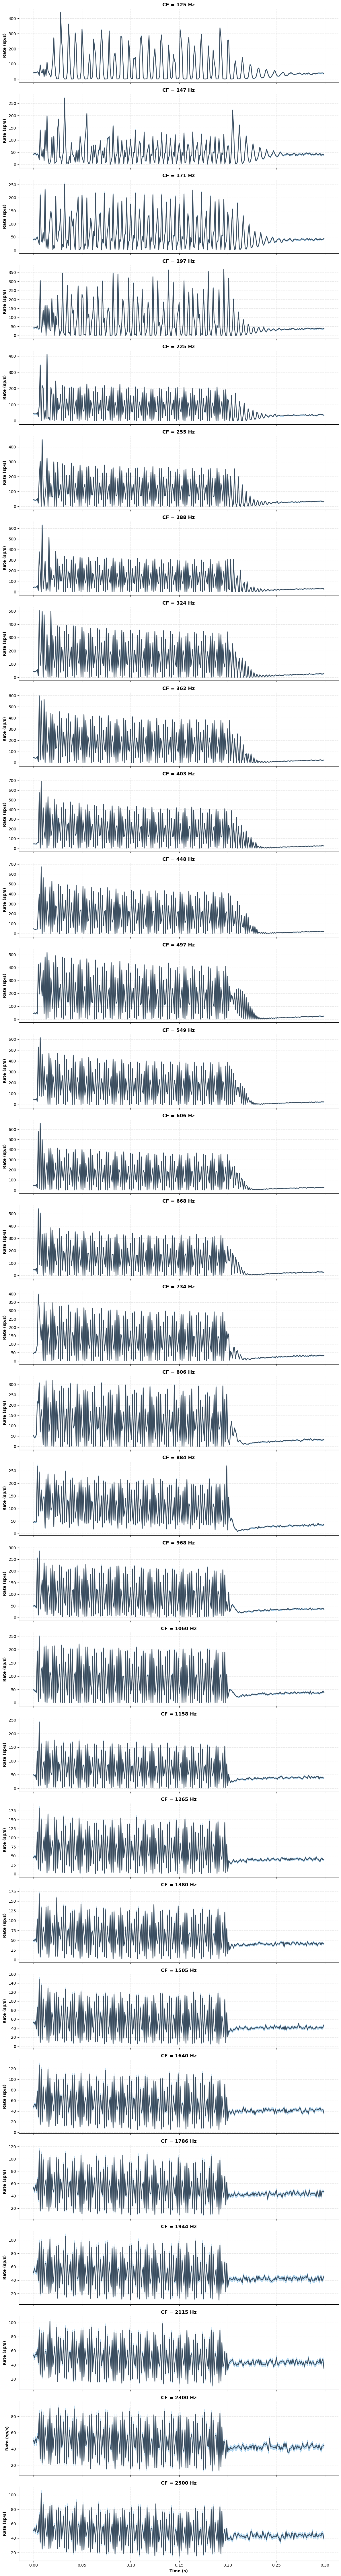

In [ ]:
num_cf = len(cf_list)

# Create directory for individual CF plots
cf_plots_dir = aggregated_dir / "cf_plots"
cf_plots_dir.mkdir(exist_ok=True)

print(f"\n📈 Creating individual plots for {num_cf} CFs...")
print(f"Saving to: {cf_plots_dir}\n")

# Plot each CF in a separate figure and save
saved_files = []
for cf_idx, cf in enumerate(cf_list):
    mean = population_rate_mean[cf_idx, :]
    sem = population_rate_sem[cf_idx, :]

    # Create individual figure for this CF
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    # Plot mean line
    ax.plot(time_axis, mean,
            linewidth=2.5,
            alpha=0.9,
            color='#2c3e50',
            label='Population Rate')

    # Plot SEM as shaded region
    ax.fill_between(time_axis, mean - sem, mean + sem,
                    alpha=0.3,
                    color='#3498db',
                    label='± SEM')

    # Formatting
    ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Population Rate (spikes/s)', fontsize=12, fontweight='bold')
    ax.set_title(f'CF = {cf:.0f} Hz (mean ± SEM, n={num_runs} runs)',
                 fontsize=14, fontweight='bold', pad=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper right', framealpha=0.9)

    plt.tight_layout()

    # Save individual figure
    output_file = cf_plots_dir / f"{filename_stem}_CF{cf:.0f}Hz.png"
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    saved_files.append(output_file)

    print(f"  ✓ Saved CF {cf:.0f} Hz → {output_file.name}")

    plt.close(fig)  # Close to free memory

print(f"\n✅ Saved {len(saved_files)} individual CF plots")
print(f"📁 Directory: {cf_plots_dir}")

# Also create a combined overview figure for quick reference
print(f"\n📊 Creating combined overview figure...")
fig, axes = plt.subplots(num_cf, 1, figsize=(12, 3 * num_cf), sharex=True)

# Make sure axes is iterable even if only one CF
if num_cf == 1:
    axes = [axes]

# Plot each CF
for cf_idx, (cf, ax) in enumerate(zip(cf_list, axes)):
    mean = population_rate_mean[cf_idx, :]
    sem = population_rate_sem[cf_idx, :]

    ax.plot(time_axis, mean, linewidth=2, alpha=0.9, color='#2c3e50')
    ax.fill_between(time_axis, mean - sem, mean + sem, alpha=0.3, color='#3498db')

    ax.set_ylabel('Rate (sp/s)', fontsize=10, fontweight='bold')
    ax.set_title(f'CF = {cf:.0f} Hz', fontsize=12, fontweight='bold', pad=5)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-1].set_xlabel('Time (s)', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save combined overview
overview_file = aggregated_dir / f"{filename_stem}_all_CFs_overview.png"
plt.savefig(overview_file, dpi=150, bbox_inches='tight')
print(f"  ✓ Saved overview → {overview_file.name}")

plt.show()